## Finished Plots

In [1]:
#Compute all KC plots
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pybdm import BDM


def create_file_list(folder_path):
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Filter for only .csv files
    csv_files = [file for file in all_files if file.endswith('.csv')]

    # Prepend the folder path to each filename
    full_paths = [os.path.join(folder_path, file) for file in csv_files]

    return full_paths

def compute_bdm(df, variables, cut=20):

    def binarize(x):
        return np.where(x < np.mean(x), 0, 1)

    def func_bdm(x):
        bdm = BDM(ndim=1)
        return bdm.bdm(x, normalized=True)

    def dataprep(x, cut=20):
        dat = np.array(x)
        dat = np.diff(dat)
        dat = [list(dat[i:i+cut]) for i in range(0, len(dat), cut)]
        dat = [binarize(x) for x in dat]
        return dat

    results = pd.DataFrame()
    for var in variables:
        dat = dataprep(df[var], cut)
        KC = [func_bdm(x) for x in dat]
        KC = pd.Series(KC).rolling(10).mean()
        results[var] = KC

    results.index = results.index * 20

    return results

def compute_averages_and_std(file_list,variables):
    # Read the first file to get the number of rows and column names
    initial_df = pd.read_csv(file_list[0])
    n_rows = len(initial_df)
    column_names = initial_df.columns

    # Initialize a dataframe to store sums, squares, and counts
    sum_df = pd.DataFrame(0.0, index=range(n_rows), columns=column_names)
    squares_df = pd.DataFrame(0.0, index=range(n_rows), columns=column_names)
    count_df = pd.DataFrame(0, index=range(n_rows), columns=column_names)

    # Iterate over each file
    for filename in file_list:
        # Load the file into a dataframe
        df = pd.read_csv(filename)
        #print dimension of df
        #print(df.shape)
        # Compute the KC values for this file
        KC_df = compute_bdm(df,variables)
        #print(KC_df.shape)
        # Add the values to the sum dataframe and squares dataframe
        sum_df += KC_df
        squares_df += KC_df**2

        # Update counts (this handles potential differences in timesteps between files)
        count_df += df.notnull()

    # Compute averages and standard deviations
    avg_df = sum_df / count_df
    std_df = np.sqrt((squares_df / count_df) - (avg_df ** 2))
    #remove columns with only NaN values
    avg_df = avg_df.dropna(axis=1, how='all')
    std_df = std_df.dropna(axis=1, how='all')

    return avg_df, std_df





## Early Warning Signals


659
655


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_33643/2722764667.py:87: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax.plot(result.index[200:], result['susceptibility'][200:], label='Susceptibility')


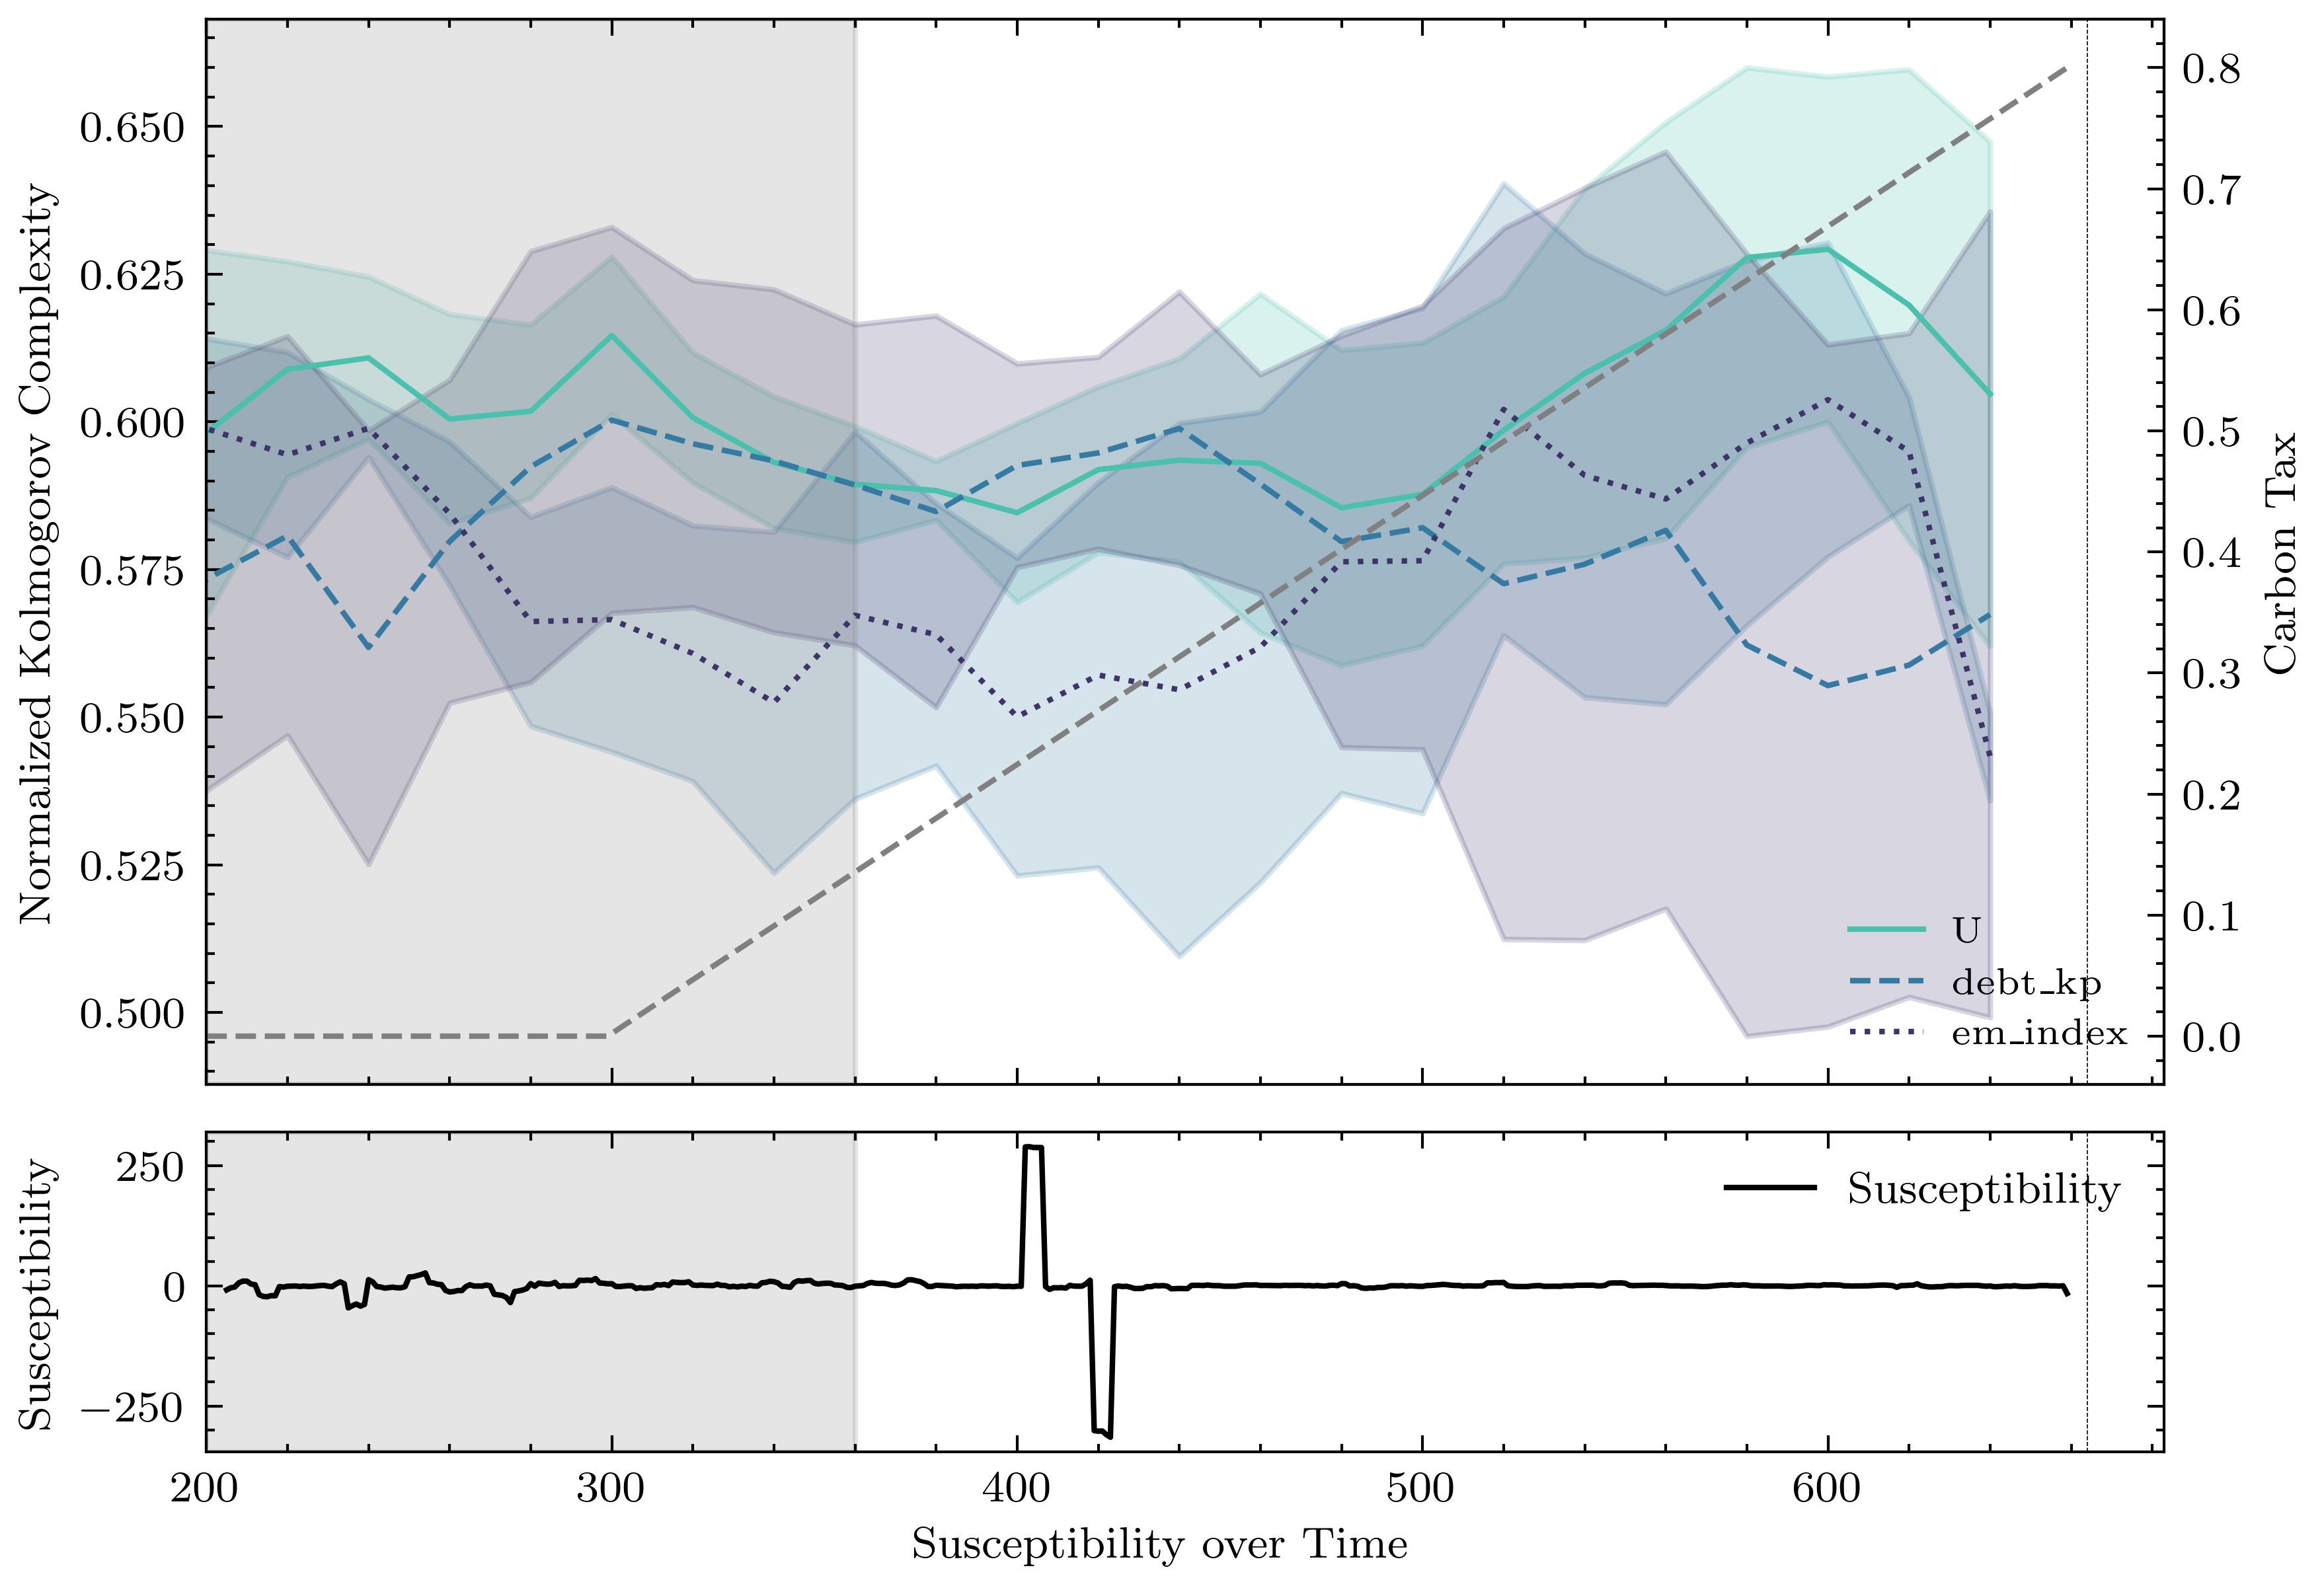

In [6]:
import matplotlib.gridspec as gridspec


def plot_on_ax(ax1, file_list, variable_names):
    mean, std = compute_averages_and_std(file_list, variable_names)
    mean = mean.dropna(axis=0, how='all')
    std = std.dropna(axis=0, how='all')
    
    palette = sns.color_palette("mako_r", len(variable_names))
    
    # Plot the dataframe on ax1
    mean.plot(ax=ax1, color=palette, linewidth=1.0)
    
    # Plot std on ax1 for all variables
    for i in range(len(variable_names)):
        ax1.fill_between(std.index, mean[variable_names[i]] - std[variable_names[i]], mean[variable_names[i]] + std[variable_names[i]], alpha=0.2, color=palette[i])
    
    ax2 = ax1.twinx()
    df_carbon = pd.read_csv(file_list[0])
    ax2.plot(df_carbon['τᶜ_ts'][200:], color='grey', linestyle='--')
    ax2.set_ylabel('Carbon Tax')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Normalized Kolmogorov Complexity')
    
    ax1.legend(loc='lower right', fontsize='small')

def compute_simple_averages(file_list, variables):
    # Initialize sum_df and count_df with zeros based on the shape of the first file
    initial_df = pd.read_csv(file_list[0])
    n_rows = len(initial_df)
    sum_df = pd.DataFrame(0.0, index=range(n_rows), columns=variables)
    count_df = pd.DataFrame(0, index=range(n_rows), columns=variables)

    # Iterate over each file
    for filename in file_list:
        # Load the file into a dataframe
        df = pd.read_csv(filename)

        # Only take the columns specified by 'variables'
        df_filtered = df[variables]

        # Add the values to sum_df and update count_df
        sum_df += df_filtered
        count_df += df_filtered.notnull()

    # Compute averages
    avg_df = sum_df / count_df
    
    # Remove columns with only NaN values
    avg_df = avg_df.dropna(axis=1, how='all')
    
    return avg_df

def calculate_susceptibility(df, time_window):
    # Calculate the rate of change for avg_norm_gdp and avg_norm_emission
    df['delta_gdp'] = df['GDP'].diff()
    df['delta_emission'] = df['em_index'].diff()

    # Drop NA rows caused by differencing
    df = df.dropna()

    # Initialize an empty DataFrame to store susceptibility values
    susceptibility_df = pd.DataFrame()
    print(len(df))
    # Loop through DataFrame based on time_window
    for start in range(0, len(df) - time_window + 1):
        end = start + time_window

        # Create a slice of the DataFrame for the current time window
        df_slice = df.iloc[start:end]

        # Calculate susceptibility for this time window
        susceptibility = (df_slice['delta_emission'] / df_slice['delta_gdp']).mean()

        # Add susceptibility value to the output DataFrame
        susceptibility_df.loc[df_slice.index[-1], 'susceptibility'] = susceptibility
    print(len(susceptibility_df))

    return susceptibility_df

def plot_susceptibility(ax, file_list, variable_names, time_window=5):
    mean = compute_simple_averages(file_list, variable_names)
    mean = (mean - mean.mean()) / mean.std()
    result = calculate_susceptibility(mean, time_window)
 
    ax.plot(result.index[200:], result['susceptibility'][200:], label='Susceptibility')
    ax.set_ylabel('Susceptibility')
    ax.legend()
    
    
    return ax


file_list = create_file_list('../results/multirun/')
variable_names1 = [
    'GDP',
    'em_index'
]
variable_names2 = [
    #'debt_cp',
    'U',
    'em_index',
    #'markup_kp',
    'debt_kp',
    #'em_index_cp',
    #'markup_cp',
    
]

# Create figure object
fig = plt.figure(figsize=(6, 4))

# Define GridSpec layout
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.3])

# Create the subplots (ax1 is the larger plot, ax2 is the smaller one)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)  # sharex ensures the x-axis is aligned



# Hide x-axis label for the top plot
ax1.set_xlabel('')
ax1.xaxis.set_tick_params(labelbottom=False)


# Use your plot_susceptibility function to populate the axes (optional)
plot_on_ax(ax1, file_list, variable_names2)
plot_susceptibility(ax2, file_list, variable_names1)

# Show the plot
plt.tight_layout()
fig.text(0.5, 0, 'Susceptibility over Time', ha='center')
ax1.set_xlim(left=200, right=ax1.get_xlim()[1])
ax2.set_xlim(left=200, right=ax2.get_xlim()[1])
#add vertical line at x = 300
ax1.axvline(x=664, color='black', linestyle='--', linewidth=0.2)
ax2.axvline(x=664, color='black', linestyle='--', linewidth=0.2)
ax1.axvspan(xmin=200, xmax=360, color='gray', alpha=0.2)
ax2.axvspan(xmin=200, xmax=360, color='gray', alpha=0.2)

#add white backgroun
fig.patch.set_facecolor('white')
plt.savefig('../results/KC_plot.png', dpi=300)
plt.show()


### NEW PANEL PLOT

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import get_cmap
from matplotlib.cm import get_cmap



cmap = get_cmap('viridis')





def plot_GDP_emissions(ax, df_mean, df_std, linspace):
    cmap = get_cmap('viridis')
    em = 0.6
    gdp = 0.4
    dn1 = 'GDP'
    dn2 = 'em_index'
    # Check if the ax object is on the left or right side
    if ax.get_subplotspec().colspan.start == 0:
        if ax.get_subplotspec().rowspan.start == 0:
            ax.errorbar(linspace, df_mean[dn1], yerr=df_std[dn1], capsize=2, fmt='o', markersize=2, color=cmap(gdp), elinewidth=0.5)
            ax.set_ylabel('(High Green Capacity)\nGDP', fontsize=5)
            ax.tick_params(axis='x', which='both', labelbottom=False, bottom=False)
            ax.yaxis.get_offset_text().set_fontsize(3)
            

            ax2 = ax.twinx()
            ax2.errorbar(linspace, df_mean[dn2], yerr=df_std[dn2], capsize=2, fmt='s', markersize=2, color=cmap(em), elinewidth=0.5)
            #ax2.tick_params(axis='y', which='both', labelright=False, right=False)
            #ax2.spines['right'].set_visible(False) 
        else:
            ax.errorbar(linspace, df_mean[dn1], yerr=df_std[dn1], capsize=2, fmt='o', markersize=2, color=cmap(gdp), elinewidth=0.5)
            ax.yaxis.get_offset_text().set_fontsize(3)
            ax.set_ylabel('(Low Green Capacity )\n GDP', fontsize=5)
            ax.spines['top'].set_visible(False)
            ax.set_xlabel('Carbon Tax \n(Low Adoption rate)', fontsize=5)
            

            ax2 = ax.twinx()
            ax2.errorbar(linspace, df_mean[dn2], yerr=df_std[dn2], capsize=2, fmt='s', markersize=2, color=cmap(em), elinewidth=0.5)
            #ax2.tick_params(axis='y', which='both', labelright=False, right=False)
            #ax2.spines['right'].set_visible(False)


        
    else:
        if ax.get_subplotspec().rowspan.start == 0:
            # Create a twin axes object for the second graph
            ax.errorbar(linspace, df_mean[dn1], yerr=df_std[dn1], capsize=2, fmt='o', markersize=2, color=cmap(gdp), elinewidth=0.5)
            ax.tick_params(axis='y', which='both', labelleft=False, left=False)
            ax.spines['left'].set_visible(False) 
            ax.tick_params(axis='x', which='both', labelbottom=False, bottom=False)
            ax.spines['bottom'].set_visible(False)

            ax2 = ax.twinx()
            ax2.errorbar(linspace, df_mean[dn2], yerr=df_std[dn2], capsize=2, fmt='s', markersize=2, color=cmap(em), elinewidth=0.5)
            ax2.set_ylabel('Final CO2 Emission-Index', fontsize=5)
        else:
            ax.errorbar(linspace, df_mean[dn1], yerr=df_std[dn1], capsize=2, fmt='o', markersize=2, color=cmap(gdp), elinewidth=0.5)
            ax.tick_params(axis='y', which='both', labelleft=False, left=False)
            ax.spines['left'].set_visible(False) 
            ax.spines['top'].set_visible(False)
            ax.set_xlabel('Carbon Tax \n(High Adoption rate)', fontsize=5)

            ax2 = ax.twinx()
            ax2.errorbar(linspace, df_mean[dn2], yerr=df_std[dn2], capsize=2, fmt='s', markersize=2, color=cmap(em), elinewidth=0.5)
            ax2.set_ylabel('Final CO2 Emission-Index', fontsize=5)


def plot_core_panel():
    path0 = "/11 Experiment"
    df_mean_mean, df_mean_std, linspace = Create_dataframe(path0)

    path1 = "/12 Experiment"
    df_mean_mean1, df_mean_std1, linspace1 = Create_dataframe(path1)

    path2 = "/13 Experiment"
    df_mean_mean2, df_mean_std2, linspace2 = Create_dataframe(path2)

    path3 = "/14 Experiment"
    df_mean_mean3, df_mean_std3, linspace3 = Create_dataframe(path3)
    
    fig, axs = plt.subplots(2, 2, constrained_layout=True)  # Create a 4x4 grid of Axes

    plt.style.use(['science','ieee'])

    #get custom colormap viridis
    

    # Call your plot functions with the appropriate axes
    #plot_function1(axs[0, 0], data1)
    plot_GDP_emissions(axs[0, 0], df_mean_mean1, df_mean_std1, linspace1)
    plot_GDP_emissions(axs[0, 1], df_mean_mean2, df_mean_std2, linspace2)
    plot_GDP_emissions(axs[1, 0], df_mean_mean, df_mean_std2, linspace)
    plot_GDP_emissions(axs[1, 1], df_mean_mean3, df_mean_std3, linspace3)

    plt.tight_layout()
    plt.show()

  
    #plot effect of progressivity on GDP with high and low carbon tax

def plot_GDP_emissions2(ax, df_mean, df_std, linspace, position):
    cmap = get_cmap('viridis')
    em = 0.75
    gdp = 0.5
    dn1 = 'GDP'
    dn2 = 'em_index'
    
    if position == 'left':
        ax.errorbar(linspace, df_mean[dn1], yerr=df_std[dn1], capsize=2, fmt='s', markersize=2, color=cmap(gdp), elinewidth=0.5, label=dn1)
        ax.set_ylabel('GDP')
        ax.set_xlabel('Carbon Tax \n (High Green Capacity)')
        #show legend 
        #ax.legend(dn1, loc='upper center')
        #ax.tick_params(axis='x', which='both', labelbottom=False, bottom=False)
        #ax.yaxis.get_offset_text().set_fontsize(3)
        
        ax2 = ax.twinx()
        ax2.errorbar(linspace, df_mean[dn2], yerr=df_std[dn2], capsize=2, fmt='o', markersize=2, color=cmap(em), elinewidth=0.5, label=dn2)
        #ax2.tick_params(axis='y', which='both', labelright=False, right=False)
        #rename legent and show it


        

    elif position == 'right':
        ax.errorbar(linspace, df_mean[dn1], yerr=df_std[dn1], capsize=2, fmt='s', markersize=2, color=cmap(gdp), elinewidth=0.5, label=dn1)
        #ax.tick_params(axis='y', which='both', labelleft=False, left=False)
        ax.set_xlabel('Carbon Tax \n (Low Green Capacity)')
        #ax.tick_params(axis='x', which='both', labelbottom=False, bottom=False)
        
        ax2 = ax.twinx()
        ax2.errorbar(linspace, df_mean[dn2], yerr=df_std[dn2], capsize=2, fmt='o', markersize=2, color=cmap(em), elinewidth=0.5, label=dn2)
        ax2.set_ylabel('Final CO2 Emission-Index')

        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='lower center')


def Create_dataframe(path1):
    warnings.simplefilter(action='ignore', category=FutureWarning)

    path = path1  
    #print files in path
    print(os.listdir(path))
    all_files = glob.glob(os.path.join(path, "*.csv"))
    all_files.sort(key=lambda x: float(x.split('_')[1]))
    start_step = float(all_files[0].split('_')[1])
    end_step = float(all_files[-1].split('_')[1])
    middle_number = float(all_files[0].split('_')[1])  # Assuming the list is already sorted
    runs = sum(1 for file in all_files if float(file.split('_')[1]) == middle_number)

    #create linespace 
    steps= int(len(all_files)/runs)
    #print(steps)
    linspace = np.linspace(float(start_step), float(end_step), steps)


    df_from_each_file = (pd.read_csv(f) for f in all_files)
    df = pd.concat(df_from_each_file, ignore_index=True)

    df_list = np.array_split(df, len(all_files))

    df_mean = pd.DataFrame()
    df_std = pd.DataFrame()
    for i in range(0, len(all_files)):
        df_mean = df_mean.append(pd.DataFrame(df_list[i].iloc[-10:].mean()).transpose())
        df_std = df_std.append(pd.DataFrame(df_list[i].iloc[-10:].std()).transpose()) 

    df_mean_mean = pd.DataFrame()
    df_mean_std = pd.DataFrame()
    
    for i in range(0, steps):
        df_mean_mean = df_mean_mean.append(pd.DataFrame(df_mean.iloc[runs*i:runs*i+runs].mean()).transpose())
        df_mean_std = df_mean_std.append(pd.DataFrame(df_mean.iloc[runs*i:runs*i+runs].std()).transpose())
    #give a warning if len(linspace) is not equal to runs
    if len(linspace) != runs:
        print("Warning: len(linspace) is not equal to runs")
        print("len(linspace) = ", len(linspace))
        print("runs = ", runs)
    
    df_mean_mean.index = linspace[::-1]
    df_mean_std.index = linspace[::-1]

    return df_mean_mean, df_mean_std, linspace

def prog_exp(ax):
    cmap = get_cmap('viridis')
    path1 = "/22 Data"
    path2 = "/23 Data"
    # hightax = os.getcwd() + path1
    # lowtax = os.getcwd() + path2
    carb_tax = 0.5
    no_tax = 0.1



    df_mean_mean1, df_mean_std1, linspace1 = Create_dataframe(path1) #with carbon tax
    df_mean_mean2, df_mean_std2, linspace2 = Create_dataframe(path2)
    #normalize gdp by first entry
    #show me the head of df_mean_mean1
    #print(df_mean_mean1.head(10))
    #check if "GDP" exists in df_mean_mean1

    scaling_factor = df_mean_mean1['GDP'].iloc[-1] #with carbon tax
    scaling_factor2 = df_mean_mean2['GDP'].iloc[-1]

    df_mean_mean1['GDP'] = df_mean_mean1['GDP']/scaling_factor#with carbon tax
    df_mean_std1['GDP'] = df_mean_std1['GDP']/scaling_factor #with carbon tax
    df_mean_mean2['GDP'] = df_mean_mean2['GDP']/scaling_factor2
    df_mean_std2['GDP'] = df_mean_std2['GDP']/scaling_factor2


    dn1 = 'GDP'

    ax.errorbar(df_mean_mean1.index, df_mean_mean1[dn1], yerr=df_mean_std1[dn1], capsize=2, fmt='s', markersize=2, color=cmap(carb_tax), elinewidth=0.5) #with carbon tax
    ax.set_xlabel('Progressivity')
    ax.set_ylabel('Normalized GDP \n (with carbon tax)')

    # Create a twin Axes sharing the x-axis
    ax2 = ax.twinx()
    ax2.errorbar(df_mean_mean2.index, df_mean_mean2[dn1], yerr=df_mean_std2[dn1], capsize=2, fmt='s', markersize=2, color=cmap(no_tax), elinewidth=0.5)
    ax2.set_ylabel('Normalized GDP \n(without carbon tax)')
    

    # Adjust the scale of the second y-axis
    #ax2.set_yscale('linear')

    # legend_handles = [
    #     mpatches.Patch(color=cmap(carb_tax), label='0.0 Carbon Tax'),
    #     mpatches.Patch(color=cmap(no_tax), label='0.5 Carbon Tax')
    # ]
    ax.yaxis.label.set_color(cmap(carb_tax))
    ax2.yaxis.label.set_color(cmap(no_tax))
    #adjust ax2 y axis limit to match ax1
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis='y', which='both', labelright=False, right=False)
    
    #axins = inset_axes(ax2, width="30%", height="30%", loc=2)
    axins = inset_axes(ax2, width="30%", height="30%", loc='upper left', bbox_to_anchor=(0.1, 0, 1, 1), bbox_transform=ax2.transAxes)
    axins.errorbar(df_mean_mean2.index, df_mean_mean2[dn1], yerr=df_mean_std2[dn1], capsize=2, fmt='s', markersize=2, color=cmap(no_tax), elinewidth=0.5)
    axins.set_adjustable('datalim')
    axins.autoscale_view()
    # Add the custom legend to the figure
    #plt.legend(handles=legend_handles, loc='upper left', prop={'size': 7})


def plot_new_panel():

    path1 = "/13 Experiment"
    df_mean_mean1, df_mean_std1, linspace1 = Create_dataframe(path1)

    path3 = "/11 Experiment"
    df_mean_mean3, df_mean_std3, linspace3 = Create_dataframe(path3)
    
    fig = plt.figure(figsize=(9, 3), constrained_layout=True)
    plt.style.use(['science', 'ieee'])

    spec = GridSpec(ncols=4, nrows=1, figure=fig, width_ratios=[1, 1, 0.05, 1])

    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])
    ax3 = fig.add_subplot(spec[0, 3])

    # Draw a vertical line to separate the rightmost subplot
    line_ax = fig.add_subplot(spec[0, 2])
    line_ax.axis('off')
    line_ax.axvline(0.5, color='k')  # Draw vertical line at the middle of this empty axes

    # Call your plot function or other plotting code here.

    plot_GDP_emissions2(ax1, df_mean_mean1, df_mean_std1, linspace1, position='left')


    plot_GDP_emissions2(ax2, df_mean_mean3, df_mean_std3, linspace3, position='right')

    prog_exp(ax3)



    plt.show()

#plot_new_panel()




    

    

len(linspace) =  20
runs =  9
len(linspace) =  20
runs =  9
len(linspace) =  20
runs =  5
len(linspace) =  20
runs =  5


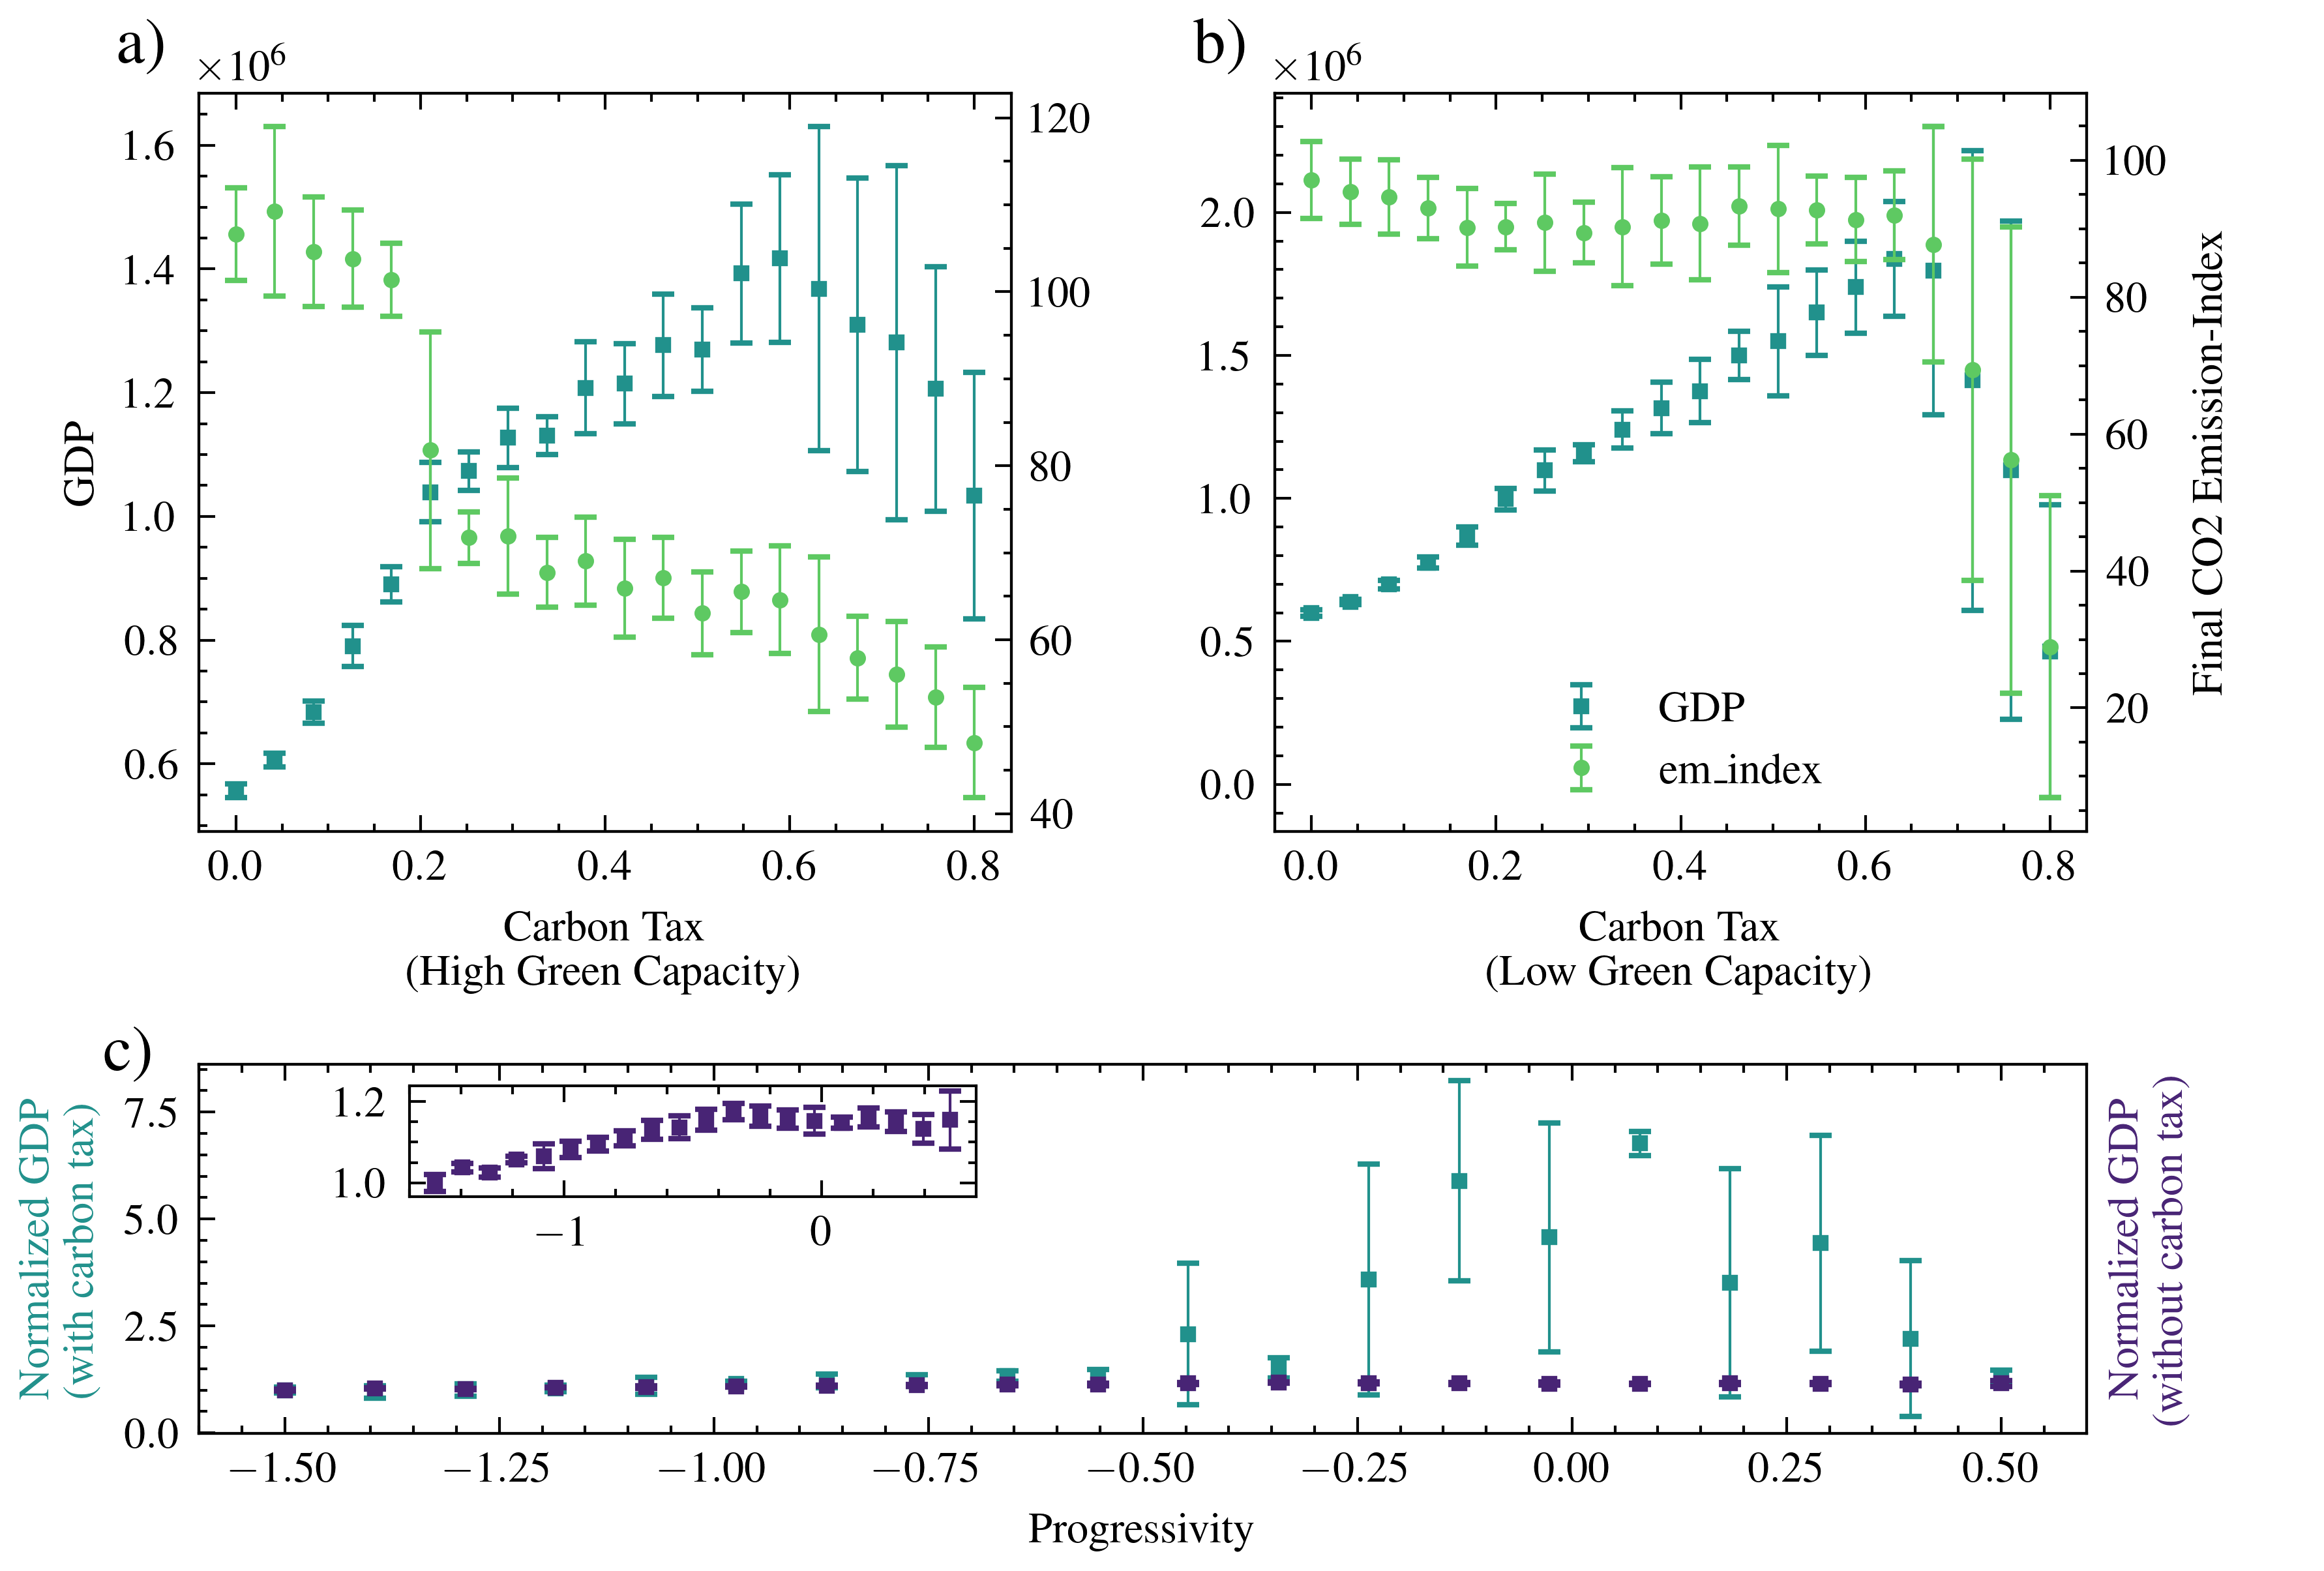

In [13]:
# from matplotlib.gridspec import GridSpec
# import scienceplots 

# def plot_new_panel():

#     path1 = "/13 Experiment"
#     df_mean_mean1, df_mean_std1, linspace1 = Create_dataframe(path1)

#     path3 = "/11 Experiment"
#     df_mean_mean3, df_mean_std3, linspace3 = Create_dataframe(path3)


#     fig = plt.figure(figsize=(8, 4), constrained_layout=True)
#     #spec = GridSpec(ncols=4, nrows=2, figure=fig, width_ratios=[1, 1, 0.05, 1])
#     spec = GridSpec(ncols=4, nrows=2, figure=fig, width_ratios=[1, 1, 0.05, 1], height_ratios=[1, 0.5])


#     # Upper plots
#     ax1 = fig.add_subplot(spec[0, 0])
#     ax2 = fig.add_subplot(spec[0, 1])

#     # Vertical separator
#     line_ax = fig.add_subplot(spec[0, 2])  # Stays in the first row
#     line_ax.axis('off')
  

#     # Lower plot stretching across both columns
#     ax3 = fig.add_subplot(spec[1, 0:2])  # Spans the first two columns in the second row
#     # Now on the lower right

#     ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')
#     ax2.text(-0.1, 1.1, 'b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top')
#     ax3.text(-0.05, 1.1, 'c)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top')

#     #use science plots
#     plt.style.use(['science', 'ieee'])
#     # Call your plot function or other plotting code here
#     plot_GDP_emissions2(ax1, df_mean_mean1, df_mean_std1, linspace1, position='left')
#     plot_GDP_emissions2(ax2, df_mean_mean3, df_mean_std3, linspace3, position='right')
#     prog_exp(ax3)

#     #make background white
#     fig.patch.set_facecolor('white')
#     plt.show()

# plot_new_panel()


['carbontax_0.12631578947368421_2.csv', 'carbontax_0.46315789473684216_3.csv', 'carbontax_0.8_4.csv', 'carbontax_0.7578947368421053_3.csv', 'carbontax_0.4210526315789474_9.csv', 'carbontax_0.6315789473684211_1.csv', 'carbontax_0.042105263157894736_1.csv', 'carbontax_0.25263157894736843_4.csv', 'carbontax_0.25263157894736843_5.csv', 'carbontax_0.4210526315789474_8.csv', 'carbontax_0.7578947368421053_2.csv', 'carbontax_0.8_5.csv', 'carbontax_0.46315789473684216_2.csv', 'carbontax_0.2105263157894737_1.csv', 'carbontax_0.5473684210526316_1.csv', 'carbontax_0.12631578947368421_3.csv', 'carbontax_0.12631578947368421_1.csv', 'carbontax_0.5473684210526316_3.csv', 'carbontax_0.2105263157894737_3.csv', 'carbontax_0.8_7.csv', 'carbontax_0.3368421052631579_9.csv', 'carbontax_0.6315789473684211_2.csv', 'carbontax_0.042105263157894736_2.csv', 'carbontax_0.25263157894736843_7.csv', 'carbontax_0.25263157894736843_6.csv', 'carbontax_0.042105263157894736_3.csv', 'carbontax_0.6315789473684211_3.csv', 'ca

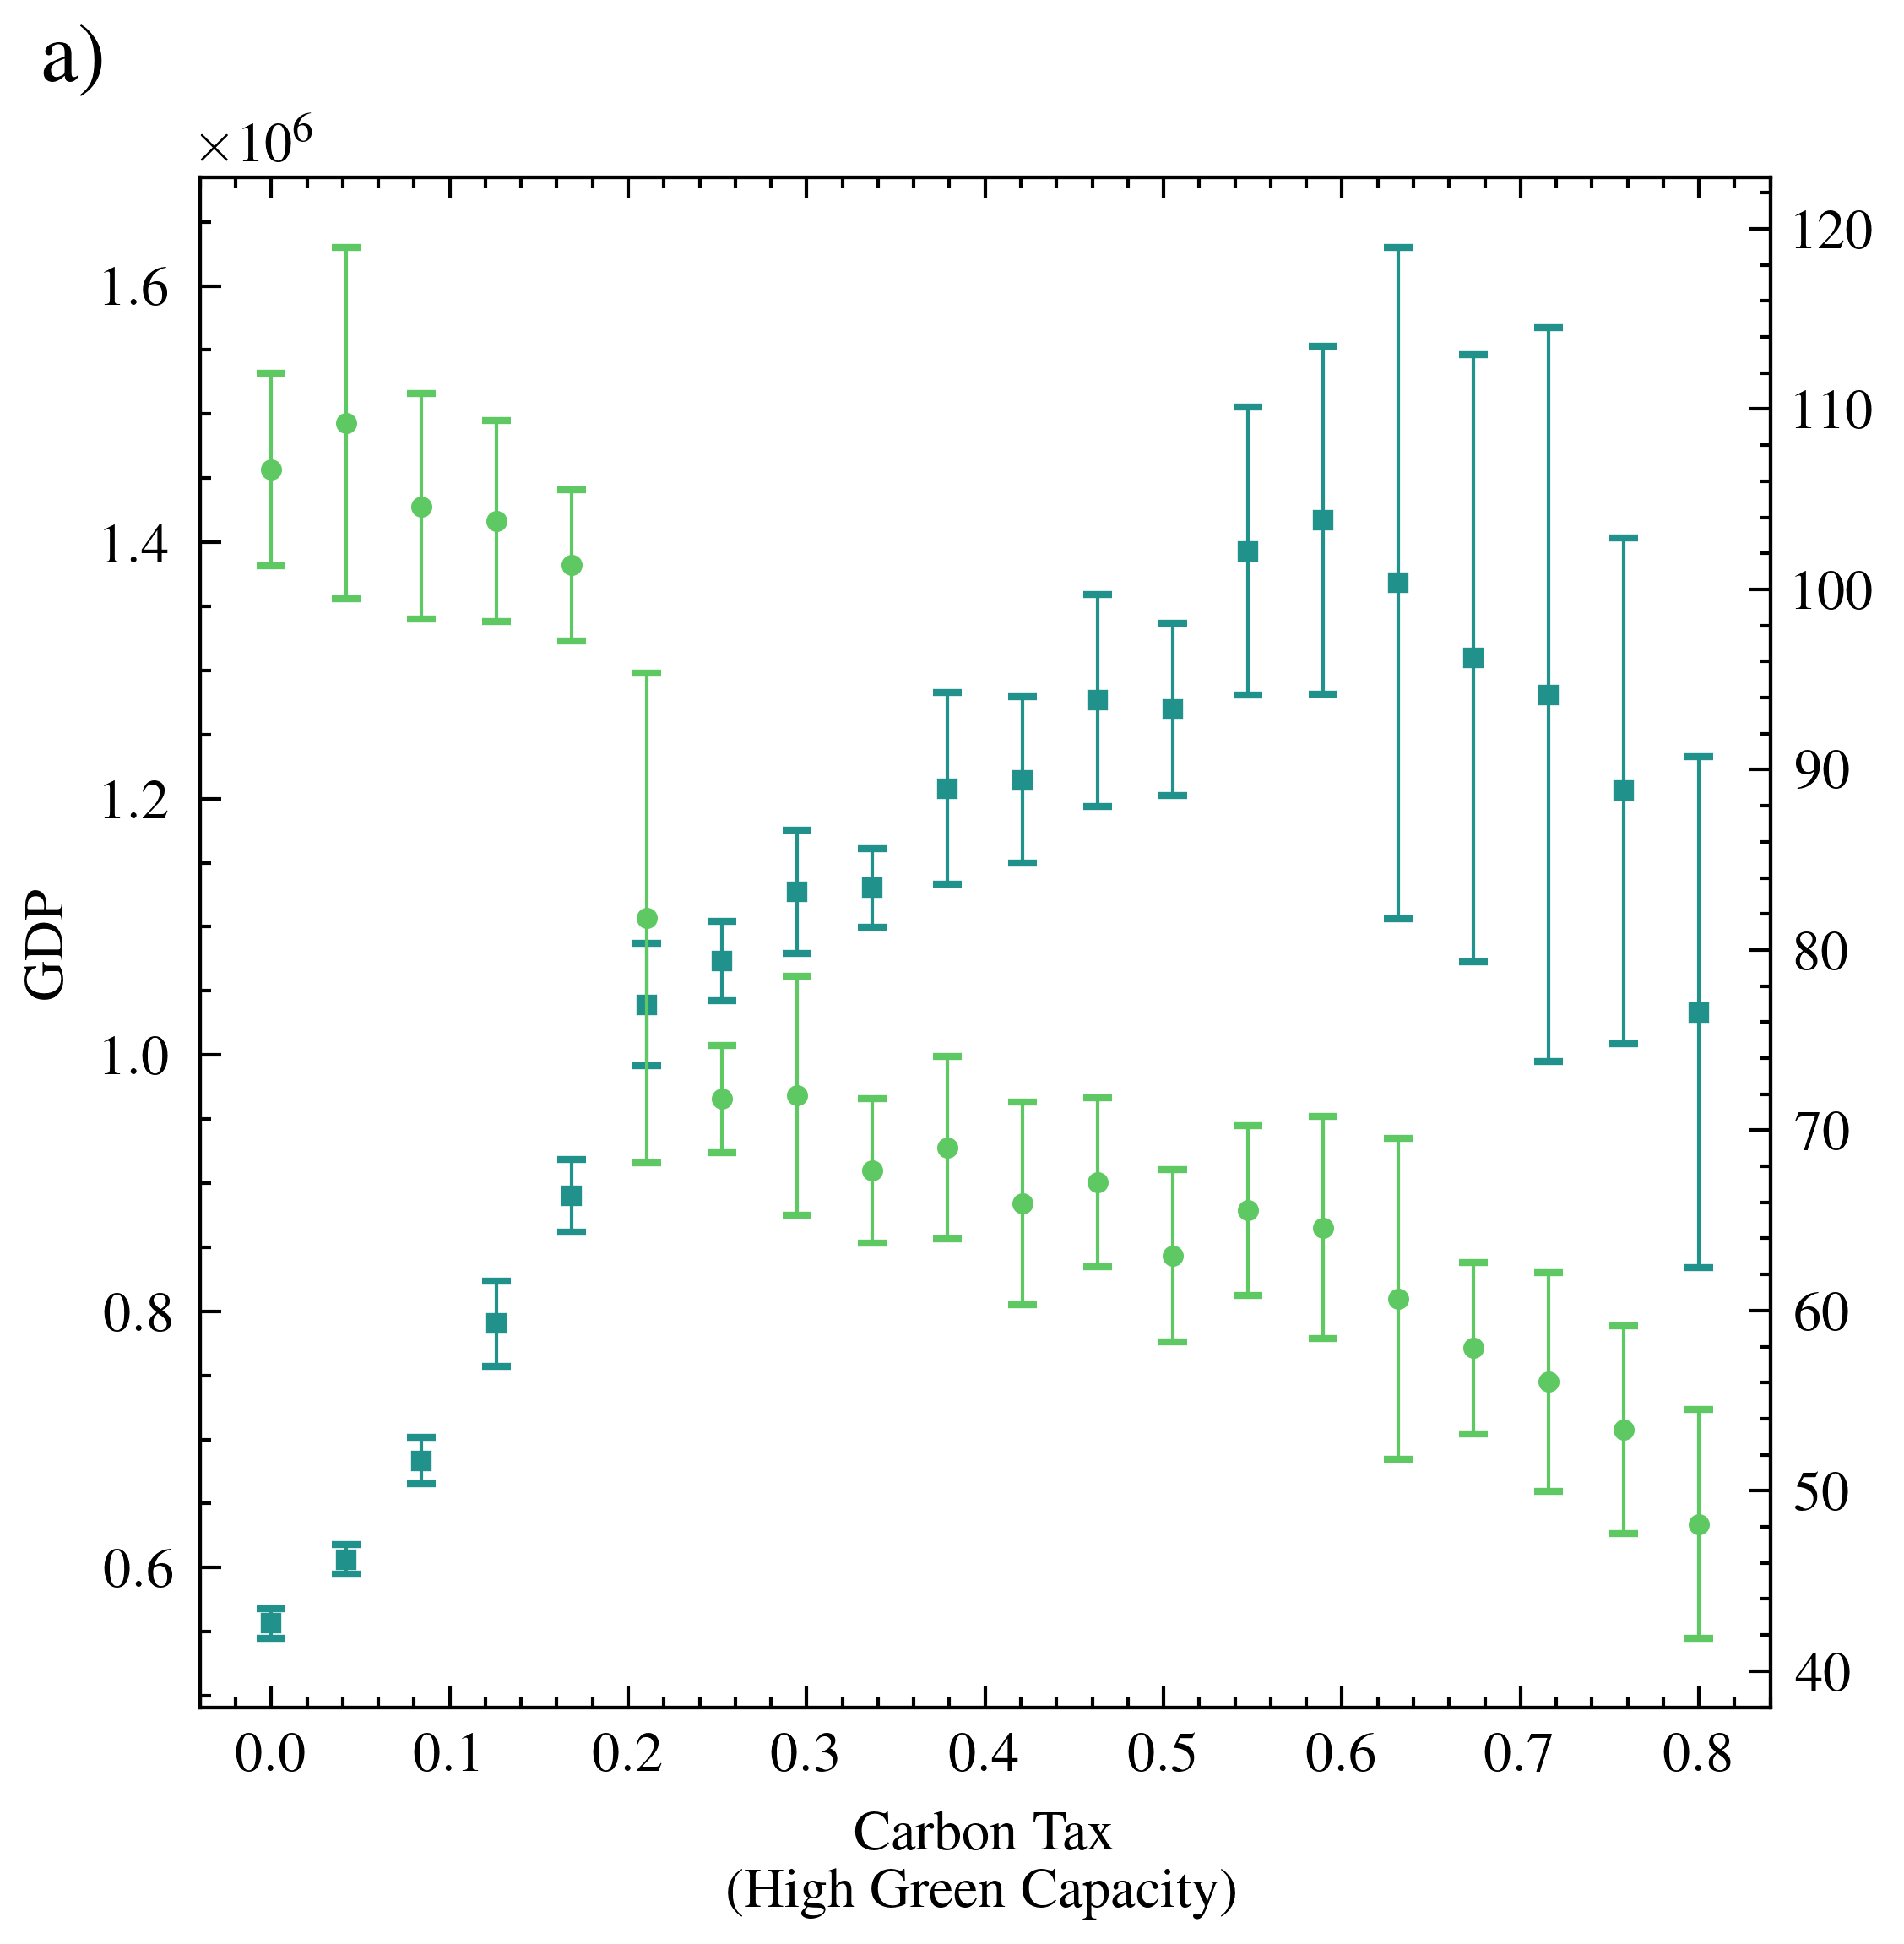

In [28]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import scienceplots 

def plot_new_panel():

    path1 = "../results/OFAT/"
    df_mean_mean1, df_mean_std1, linspace1 = Create_dataframe(path1)

    fig = plt.figure(figsize=(4, 4))  # Adjust size as needed
    spec = GridSpec(ncols=1, nrows=1, figure=fig)

    # Upper left plot
    ax1 = fig.add_subplot(spec[0, 0])

    ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')

    # Use science plots
    plt.style.use(['science', 'ieee'])
    # Call your plot function or other plotting code here
    plot_GDP_emissions2(ax1, df_mean_mean1, df_mean_std1, linspace1, position='left')

    # Make background white
    fig.patch.set_facecolor('white')
    plt.savefig('../results/Critical transition', dpi=300)
    plt.show()

plot_new_panel()
